## Load the data

In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
data.sample(10)

,headlines,text
92598,Turkey election board rejects referendum annul...,Turkey's Supreme Election Board on Wednesday r...
60639,CBI to look for missing JNU student Najeeb in ...,"The Central Bureau of Investigation, which is ..."
59788,Parliament winter session not to clash with st...,Amidst Congress' claims that the government wa...
52709,Jimmy Kimmel marks Trump's '2000th lie' with a...,American television host Jimmy Kimmel marked P...
43807,Stone Age people in SA survived supervolcano e...,"A supervolcano eruption 74,000 years ago in In..."
88264,Tiger Shroff unveils first look poster of 'Ram...,Actor Tiger Shroff took to Twitter to share th...
80724,"There's nothing I miss about India, says Vijay...","When asked if he missed India, Vijay Mallya sa..."
89246,"US approves sale of missiles worth Ã¢ÂÂ¹12,80...",The US State Department has approved the sale ...
19099,Hotel installs robot 'dinosaurs' at the recept...,A hotel in Japan has installed robot 'dinosaur...
70787,SEBI plans to reduce mutual fund schemes by half,SEBI's mutual fund advisory panel has reported...


text는 본문, headlines는 요약으로 구성된 데이터입니다. 따라서 추상적 요약을 하는 경우에는 text를 본문, headlines를 요약된 데이터로 삼아서 학습을 진행하면 되고, 추출적 요약을 하는 경우에는 text열만 사용하면 됩니다.

In [5]:
original_data = data.copy()

## Preprocessing

### (1) `dropna`, `drop_duplicates`

In [324]:
print(f"전체 샘플 수: {len(data)}")
print(f"text열에서 중복을 배제한 유일한 샘플의 수: {data['text'].nunique()}")
print(f"headlines열에서 중복을 배제한 유일한 샘플의 수: {data['headlines'].nunique()}")

전체 샘플 수: 98401
text열에서 중복을 배제한 유일한 샘플의 수: 98360
headlines열에서 중복을 배제한 유일한 샘플의 수: 98280


요약은 중복된 경우가 충분히 나올 수 있으므로 text열에서 중복이 되는 샘플을 확인 후 지워주겠습니다.

In [325]:
data[data.duplicated('text')].sort_values(by='text')['text']

78519    A TechCrunch report has claimed that IndiaÃ¢Â...
80355    As many as 54,250 fluorescent-yellow tennis ba...
84724    Australia won the 1999 Cricket World Cup after...
52021    Australia's Anthony Stuart took a hat-trick in...
70392    Before India-England 2011 World Cup match, for...
44594    Berger Paints has launched Berger Express Pain...
81352    Born on July 10, 1856, Serbian inventor Nikola...
63533    Born on October 30, 1909, Padma Bhushan-awarde...
78521    CARS24 has enabled car owners to sell their ca...
53865    Cricket legend Don Bradman reversed the Austra...
55208    During an El ClÃÂ¡sico match in 2002, Barcelo...
53731    England captain Mike Denness left himself out ...
59705    England was beaten at home for the first time ...
74095    English astronomer Arthur Eddington used 1919'...
60885    Fijian cricketer Ilikena Lasarusa Talebulamain...
61445    Former Australian fast bowler Glenn McGrath, w...
54078    Former Australian leg-spinner Shane Warne was .

In [326]:
data.drop_duplicates(subset=['text'], inplace=True)
print(f"전체 샘플 수: {len(data)}")

전체 샘플 수: 98360


중복은 제거했지만 null값을 확인해보고 제외해주겠습니다.

In [327]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


확인결과 null값이 없으므로 추가적인 삭제는 해주지 않아도 될 것 같습니다.

### (2) Text normalization
전처리과정에서 동일한 의미를 가지지만 축약형으로 표현이 된 단어들을 풀어줘 같은 단어로 인식이 되게끔 text normalization(텍스트 정규화)을 진행하겠습니다. 

우선은 노드에서 사용된 정규화 사전을 그대로 사용하겠습니다.

In [328]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### Remove stopwords
학습에 도움이 되지 않는다고 판단이 되는 stopwords들을 제거해주겠습니다. 이번에도 nltk에서 제공하는 불용어 리스트를 참조해 불용어를 제거해보겠습니다.

In [329]:
print(f"불용어 갯수: {len(stopwords.words('english'))}")
print(stopwords.words('english'))

불용어 갯수: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [330]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, 'lxml').text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"', '', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b", "", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
        
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens


In [331]:
sample_text = "When he was not there, she shouldn't have been there."
print(f"When removing stopwords: {preprocess_sentence(sample_text, True)}")
print(f"When not removing stopwords: {preprocess_sentence(sample_text, False)}")

When removing stopwords: 
When not removing stopwords: when he was not there she should not have been there


불용어 자체를 어느정도 수정해 줄 필요도 있다고 생각이 드는 부분입니다. 'When he was not there, she shouldn't be there.' 의 경우 모든 단어를 불용어로 분류해서 없애버리기도 합니다.

전처리의 속도를 올리기 위해 multi-processing을 이용하겠습니다.

In [332]:
import multiprocessing as mp
from multiprocessing import Pool
import numpy as np
import time
from functools import partial

start = time.time()

def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()
    
    text_data_split = np.array_split(data, num_cores)
    pool = Pool(num_cores)
    
    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))
    pool.close()
    pool.join()
    
    print(time.time() - start_time, " seconds")
    return processed_data

In [333]:
clean_text = preprocess_data(data['text'])
print(clean_text)

182.40769004821777  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [334]:
clean_headlines = preprocess_data(data['headlines'])
print(clean_headlines)

38.42037057876587  seconds
['upgrad learner switches career ml al salary hike'
 'delhi techie wins free food swiggy one year cred'
 'new zealand end rohit sharma led india match winning streak' ...
 'matrix film get reboot reports'
 'snoop dogg aims gun clown dressed trump new video'
 'madhesi morcha withdraws support nepalese government']


In [335]:
original_data = data.copy()

In [336]:
len(clean_text)

98360

In [337]:
data['text'] = clean_text
data['headlines'] = clean_headlines

In [338]:
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

공백을 nan으로 바꿔준 후 버리는 과정을 진행하려고 했지만 공백이 없어서 nan값이 없어서 별도로 진행해주지 않았습니다.

### max length of samples

In [339]:
import matplotlib.pyplot as plt
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print(f"텍스트의 최소 길이: {np.min(text_len)}")
print(f"텍스트의 최대 길이: {np.max(text_len)}")
print(f"텍스트의 평균 길이: {np.mean(text_len)}")
print(f"요약의 최소 길이: {np.min(headlines_len)}")
print(f"요약의 최대 길이: {np.max(headlines_len)}")
print(f"요약의 평균 길이: {np.mean(headlines_len)}")

텍스트의 최소 길이: 1
텍스트의 최대 길이: 60
텍스트의 평균 길이: 35.09968483123221
요약의 최소 길이: 1
요약의 최대 길이: 13
요약의 평균 길이: 7.136183407889386


Text(0.5, 1.0, 'Text')

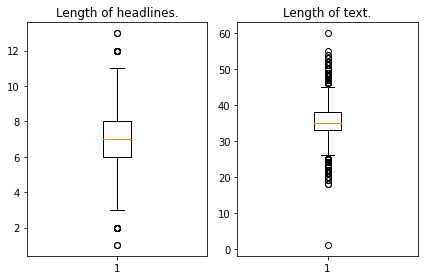

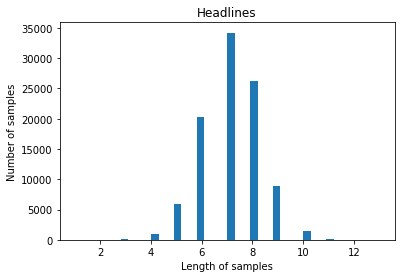

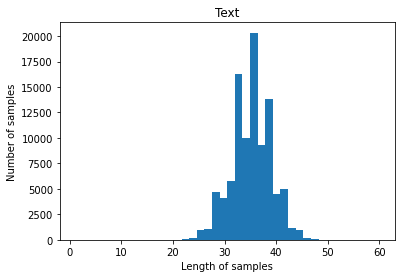

In [340]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axs = axes.ravel()

axs[0].boxplot(headlines_len)
axs[0].set_title("Length of headlines.")

axs[1].boxplot(text_len)
axs[1].set_title("Length of text.")

fig.tight_layout()

fig2, ax2 = plt.subplots()
ax2.hist(headlines_len, bins=40)
ax2.set_xlabel("Length of samples")
ax2.set_ylabel("Number of samples")
ax2.set_title("Headlines")

fig3, ax3 = plt.subplots()
ax3.hist(text_len, bins=40)
ax3.set_xlabel("Length of samples")
ax3.set_ylabel("Number of samples")
ax3.set_title("Text")

텍스트의 최대 길이는 45, 요약(headlines)의 최대길이는 8로 설정해서 문제를 풀어보겠습니다.

In [341]:
text_max_len = 45
headlines_max_len = 8

In [342]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt+1
            
    print(f"전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {cnt/len(nested_list):.2%}")

In [343]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 99.68%
전체 샘플 중 길이가 8 이하인 샘플의 비율: 89.26%


In [344]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print(f"전체 샘플수 : {len(data)}")

전체 샘플수 : 87587


In [345]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x) 
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
7,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...
9,cong wins ramgarh bypoll rajasthan takes total...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll rajasthan ta...,cong wins ramgarh bypoll rajasthan takes total...


In [346]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [347]:
indices = np.arange(encoder_input.shape[0])

rng = np.random.default_rng()
rng.shuffle(indices)

print(indices)

[44648 17471 33531 ...  9926 67386 84649]


In [348]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [349]:
n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수: ',  n_of_val)

테스트 데이터의 수:  17517


In [350]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 70070
훈련 레이블의 개수 : 70070
테스트 데이터의 개수 : 17517
테스트 레이블의 개수 : 17517


In [351]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [352]:
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기: ", total_cnt)
print(f"등장빈도가 {threshold-1}번 이하인 희귀 단어의 수: {rare_cnt}")
print(f"단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: {total_cnt - rare_cnt}")
print("단어 집합에서 희귀 단어의 비율: ", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기:  65981
등장빈도가 8번 이하인 희귀 단어의 수: 47658
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 18323
단어 집합에서 희귀 단어의 비율:  72.22988436064928
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.546670539004945


In [353]:
src_vocab = 18500 ## 희귀 단어를 제외한 단어 집합의 크기
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [354]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[101, 188, 860, 1172, 518, 2817, 529, 4132, 4212, 742, 509, 306, 15763, 4497, 1513, 11750, 148, 4987, 12129, 614, 15764, 50, 144, 409, 23, 1813, 371, 437, 13, 278, 1662, 2421, 45, 227, 405, 3976, 352, 29, 4, 1173], [30, 26, 63, 2889, 3019, 2351, 12130, 60, 20, 3616, 339, 27, 4173, 3168, 700, 1322, 5355, 910, 4305, 759, 29, 8062, 5668, 563, 5668, 171, 1284, 204, 1769, 3564, 2922, 111, 15053, 621, 2731, 243], [484, 329, 107, 7133, 6376, 109, 83, 44, 4079, 627, 159, 1255, 266, 4, 15, 1330, 31, 3226, 2352, 9575, 781, 386, 571, 9576, 10788, 1174, 92, 411, 2693, 1814, 6376, 976, 1637, 571, 202, 529, 1579, 6802, 386, 571, 4]]


In [355]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [356]:
threshold = 9
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

        
print("단어 집합(vocabulary)의 크기: ", total_cnt)
print(f"등장빈도가 {threshold-1}번 이하인 희귀 단어의 수: {rare_cnt}")
print(f"단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: {total_cnt - rare_cnt}")
print("단어 집합에서 희귀 단어의 비율: ", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기:  28406
등장빈도가 8번 이하인 희귀 단어의 수: 20847
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 7559
단어 집합에서 희귀 단어의 비율:  73.38942476941492
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.143013248567588


In [357]:
tar_vocab = 7500
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ', decoder_input_train[:5])
print('target')
print('target ', decoder_target_train[:5])

input
input  [[1, 27, 1277, 1748, 1070, 1026, 262, 2527, 13], [1, 2147, 199, 7, 1037], [1, 5286, 1014, 201, 4033, 64, 436, 1393], [1, 773, 1510, 565, 1071, 547, 177, 2295], [1, 46, 12, 95, 135, 1251, 231]]
target
target  [[27, 1277, 1748, 1070, 1026, 262, 2527, 13, 2], [2147, 199, 7, 1037, 2], [5286, 1014, 201, 4033, 64, 436, 1393, 2], [773, 1510, 565, 1071, 547, 177, 2295, 2], [46, 12, 95, 135, 1251, 231, 2]]


In [358]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 갯수: ', len(drop_train))
print('삭제할 테스트 데이터의 갯수: ', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 갯수: ', len(encoder_input_train))
print('훈련 레이블의 갯수: ', len(decoder_input_train))
print('테스트 데이터의 갯수: ', len(encoder_input_test))
print('테스트 레이블의 갯수: ', len(decoder_input_test))

삭제할 훈련 데이터의 갯수:  5
삭제할 테스트 데이터의 갯수:  1
훈련 데이터의 갯수:  70065
훈련 레이블의 갯수:  70065
테스트 데이터의 갯수:  17516
테스트 레이블의 갯수:  17516


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [359]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Building models(Baseline)
노드의 전처리방법, 모델의 구조를 그대로 사용하여 성능의 Baseline을 잡아보겠습니다.

In [360]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len, ))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [361]:
decoder_inputs = Input(shape=(None, ))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [362]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 45, 128)      2368000     input_41[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 45, 256), (N 394240      embedding_8[0][0]                
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [363]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [364]:
attn_layer = AttentionLayer(name='attention_layer')

attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 45, 128)      2368000     input_41[0][0]                   
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 45, 256), (N 394240      embedding_8[0][0]                
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [365]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
274/274 [==============================] - 209s 722ms/step - loss: 6.5918 - val_loss: 5.8943
Epoch 2/50
274/274 [==============================] - 198s 722ms/step - loss: 5.8090 - val_loss: 5.5215
Epoch 3/50
274/274 [==============================] - 199s 725ms/step - loss: 5.4182 - val_loss: 5.2295
Epoch 4/50
274/274 [==============================] - 199s 728ms/step - loss: 5.1099 - val_loss: 5.0123
Epoch 5/50
274/274 [==============================] - 199s 725ms/step - loss: 4.8564 - val_loss: 4.8540
Epoch 6/50
274/274 [==============================] - 198s 723ms/step - loss: 4.6414 - val_loss: 4.7263
Epoch 7/50
274/274 [==============================] - 200s 731ms/step - loss: 4.4558 - val_loss: 4.6276
Epoch 8/50
274/274 [==============================] - 198s 723ms/step - loss: 4.3032 - val_loss: 4.5389
Epoch 9/50
274/274 [==============================] - 198s 724ms/step - loss: 4.1585 - val_loss: 4.4768
Epoch 10/50
274/274 [==============================] - 197s 721m

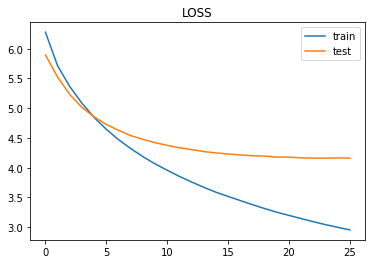

In [366]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LOSS')
plt.legend()
plt.show()

**val_loss가 약 4.1606정도에서 멈췄습니다.**

## Inference Model

In [367]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [368]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [369]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [370]:
decoder_model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 128)    960000      input_42[0][0]                   
__________________________________________________________________________________________________
input_43 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           [(None, 256)]        0                                            
___________________________________________________________________________________________

In [371]:
def decode_sequence(input_seq):
    
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if (sampled_token != 'eostoken'):
            decoded_sentence += ' ' + sampled_token
            
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        e_h, e_c = h, c
        
    return decoded_sentence

In [372]:
def seq2text(input_seq):
    temp = ''
    
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i] + ' '
    
    return temp

def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
            
    return temp

In [373]:
for i in range(44, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : parliamentary panel headed congress leader chidambaram wednesday informed crpf personnel posted chhattisgarh naxal hit areas facing difficulties getting daily meals panel recommended mechanism developed ensuring regular supply food jawans panel also expressed anguish conditions jawans country 
실제 요약 : garh crpf jawans face problem getting food chidambaram 
예측 요약 :  andhra govt seeks permission suicide


원문 : austrian man sued daughter taking long complete undergraduate studies took complete degree usually takes eight supreme court decided father case ruling obliged pay months fees 
실제 요약 : man sues daughter taking long graduate 
예측 요약 :  man gets life old degree


원문 : cricketers kl rahul hardik pandya suspended remarks women koffee karan harbhajan singh said would want travel bus wife daughter put everyone reputation stake never created kind culture team added 
실제 요약 : travel hardik rahul bus family harbhajan 
예측 요약 :  pandya rahul wear women


원문 : actor tom known films like pea

## 전처리를 다르게 해보기(1)

In [6]:
data = original_data.copy()

### (1) `dropna`, `drop_duplicates` - 기존과 똑같음.

In [7]:
print(f"전체 샘플 수: {len(data)}")
print(f"text열에서 중복을 배제한 유일한 샘플의 수: {data['text'].nunique()}")
print(f"headlines열에서 중복을 배제한 유일한 샘플의 수: {data['headlines'].nunique()}")

전체 샘플 수: 98401
text열에서 중복을 배제한 유일한 샘플의 수: 98360
headlines열에서 중복을 배제한 유일한 샘플의 수: 98280


요약은 중복된 경우가 충분히 나올 수 있으므로 text열에서 중복이 되는 샘플을 확인 후 지워주겠습니다.

In [8]:
data[data.duplicated('text')].sort_values(by='text')['text']

78519    A TechCrunch report has claimed that IndiaÃ¢Â...
80355    As many as 54,250 fluorescent-yellow tennis ba...
84724    Australia won the 1999 Cricket World Cup after...
52021    Australia's Anthony Stuart took a hat-trick in...
70392    Before India-England 2011 World Cup match, for...
44594    Berger Paints has launched Berger Express Pain...
81352    Born on July 10, 1856, Serbian inventor Nikola...
63533    Born on October 30, 1909, Padma Bhushan-awarde...
78521    CARS24 has enabled car owners to sell their ca...
53865    Cricket legend Don Bradman reversed the Austra...
55208    During an El ClÃÂ¡sico match in 2002, Barcelo...
53731    England captain Mike Denness left himself out ...
59705    England was beaten at home for the first time ...
74095    English astronomer Arthur Eddington used 1919'...
60885    Fijian cricketer Ilikena Lasarusa Talebulamain...
61445    Former Australian fast bowler Glenn McGrath, w...
54078    Former Australian leg-spinner Shane Warne was .

In [9]:
data.drop_duplicates(subset=['text'], inplace=True)
print(f"전체 샘플 수: {len(data)}")

전체 샘플 수: 98360


중복은 제거했지만 null값을 확인해보고 제외해주겠습니다.

In [10]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


확인결과 null값이 없으므로 추가적인 삭제는 해주지 않아도 될 것 같습니다.

### (2) Text normalization
전처리과정에서 동일한 의미를 가지지만 축약형으로 표현이 된 단어들을 풀어줘 같은 단어로 인식이 되게끔 text normalization(텍스트 정규화)을 진행하겠습니다. 

우선은 노드에서 사용된 정규화 사전을 그대로 사용하겠습니다.

텍스트 정규화에도 stemmization, lemmatization과 같은 다양한 방법이 있습니다. 해당 방법은 사용하지는 않았으나 참고를 위해 링크를 남겨두겠습니다. [링크](https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646)

In [11]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### Remove stopwords
학습에 도움이 되지 않는다고 판단이 되는 stopwords들을 제거해주겠습니다. 이번에도 nltk에서 제공하는 불용어 리스트를 참조해 불용어를 제거해보겠습니다.

위에서 불용어 처리를 하면서 예로 들었던 "When he was not there, she shouldn't have been there." 라는 문장이 기억나시나요? 그가 거기 없었을 때, 그녀는 거기 있었으면 안됐다. 라는 뜻의 이 문장은 불용어 처리를 통해 완전히 사라지게 됩니다. 

불용어는 문맥상 의미가 없다고 판단되어 지워지는 단어인데 얼핏 보기에도 'no', 'nor', 'not' 는 의미가 중요해보입니다.

전반적인 전처리의 순서가 
1. 소문자
2. HTML 태그제거
3. 괄호로 닫힌 문자열제거
4. "" 제거
5. contractions(축약어) 제거
6. 소유격제거
7. 영어 외 문자 제거
8. 3개 이상의 m을 mm으로 바꿔주는 과정
9. 불용어 제거

로 마지막에 불용어 제거를 하므로 원래의 불용어에서 'no', 'nor', 'not' 등만 제외하고 새로운 리스트를 만들어보겠습니다.


In [12]:
print(f"불용어 갯수: {len(stopwords.words('english'))}")
print(stopwords.words('english'))

불용어 갯수: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [13]:
stopwords_list = stopwords.words('english')
stopwords_list.remove('no')
stopwords_list.remove('nor')
stopwords_list.remove('not')

print(f"수정한 불용어 갯수: {len(stopwords_list)}")

수정한 불용어 갯수: 176


3개가 제외된 값이 맞으므로 의도대로 삭제된 것을 볼 수 있습니다.

기존의 전처리에서는 마지막에 정규표현식으로 'ummmmmm' -> 'umm' 과 같은 식으로 바꿔주는 부분이 있었습니다. 영어에서는 어떤 문자든 세개 이상 반복되면 하이픈을 붙여주고 있습니다. 예를 들어 bee-eater, shell-less 와 같은식으로 구분해서 표기를 하는 방식을 사용하고 있습니다.

이런식의 표기에서 특수문자를 공백으로 별개의 단어로 구분을 해준다면 bee-eater, shell-less와 같은 단어는 살아남고 오히려 같은 알파벳(character)가 3번 이상 나오면 아얘 삭제를 하는 방향으로 진행해보겠습니다.

또한 mm, Zz와 같이 단독적으로 존재하는 2번 이상의 알파벳 단어를 삭제했습니다. 5mm와 같은 경우는 의미가 있으므로 삭제되지 않습니다.

간단한 예제로 확인해보겠습니다.

In [14]:
sentence = 'cross-section'
sentence = sentence.lower()
sentence = BeautifulSoup(sentence, 'lxml').text
sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
sentence = re.sub('"', '', sentence)
sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
sentence = re.sub(r"'s\b", "", sentence)
sentence = re.sub("[^a-zA-Z0-9]", " ", sentence)
sentence = re.sub("(.)\\1{2,}", '', sentence)
sentence = re.sub("\s(.)\\1{1,}", ' ', sentence)
sentence = re.sub("(^| ).( |$)", ' ', sentence)
sentence = re.sub(' +', ' ', sentence)
sentence = sentence.strip()
print(sentence)

sentence = 'Ummmm, maybe, Ummmm, that is 5mm size bee-eater. zzz'
sentence = sentence.lower()
sentence = BeautifulSoup(sentence, 'lxml').text
sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
sentence = re.sub('"', '', sentence)
sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
sentence = re.sub(r"'s\b", "", sentence)
sentence = re.sub("[^a-zA-Z0-9]", " ", sentence) # 추가
sentence = re.sub("(.)\\1{2,}", ' ', sentence)
sentence = re.sub("\s(.)\\1{1,}", ' ', sentence) # 추가
sentence = re.sub("(^| ).( |$)", ' ', sentence)
sentence = re.sub(' +', ' ', sentence)
sentence = sentence.strip()
print(sentence)

sentence = original_data['headlines'][0]
sentence = sentence.lower()
sentence = BeautifulSoup(sentence, 'lxml').text
sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
sentence = re.sub('"', '', sentence)
sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
sentence = re.sub(r"'s\b", "", sentence)
sentence = re.sub("[^a-zA-Z0-9]", " ", sentence) # 추가
sentence = re.sub("(.)\\1{2,}", ' ', sentence)
sentence = re.sub("\s(.)\\1{1,}", ' ', sentence) # 추가
sentence = re.sub("(^| ).( |$)", ' ', sentence)
sentence = re.sub(' +', ' ', sentence)
sentence = sentence.strip()
print(sentence)

cross section
maybe that is 5mm size bee eater
upgrad learner switches to career in ml al with 90 salary hike


In [16]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, 'lxml').text
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"', '', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b", "", sentence)
    sentence = re.sub("[^a-zA-Z0-9]", " ", sentence) # 추가
    sentence = re.sub("(.)\\1{2,}", ' ', sentence)
    sentence = re.sub("\s(.)\\1{1,}", ' ', sentence) # 추가
    sentence = re.sub("(^| ).( |$)", ' ', sentence)
    sentence = re.sub(' +', ' ', sentence)
    sentence = sentence.strip()
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords_list if len(word) > 1)
        
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens


In [17]:
sample_text = "When he was not there, she shouldn't have been there."
print(f"When removing stopwords: {preprocess_sentence(sample_text, True)}")
print(f"When not removing stopwords: {preprocess_sentence(sample_text, False)}")

When removing stopwords: not not
When not removing stopwords: when he was not there she should not have been there


전처리의 속도를 올리기 위해 multi-processing을 이용하겠습니다.

In [18]:
import multiprocessing as mp
from multiprocessing import Pool
import numpy as np
import time
from functools import partial

start = time.time()

def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()
    
    text_data_split = np.array_split(data, num_cores)
    pool = Pool(num_cores)
    
    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))
    pool.close()
    pool.join()
    
    print(time.time() - start_time, " seconds")
    return processed_data

In [19]:
clean_text = preprocess_data(data['text'])
print(clean_text)

10.465738773345947  seconds
['saurav kant alumnus upgrad pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film scr

In [20]:
clean_headlines = preprocess_data(data['headlines'])
print(clean_headlines)

6.903073072433472  seconds
['upgrad learner switches career ml al 90 salary hike'
 'delhi techie wins free food swiggy one year cred'
 'new zealand end rohit sharma led india 12 match winning streak' ...
 'matrix film get reboot reports'
 'snoop dogg aims gun clown dressed trump new video'
 'madhesi morcha withdraws support nepalese government']


In [21]:
len(clean_text)

98360

In [22]:
data['text'] = clean_text
data['headlines'] = clean_headlines

In [23]:
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

공백을 nan으로 바꿔준 후 버리는 과정을 진행하려고 했지만 공백이 없어서 nan값이 없어서 별도로 진행해주지 않았습니다.

### max length of samples

In [24]:
import matplotlib.pyplot as plt
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print(f"텍스트의 최소 길이: {np.min(text_len)}")
print(f"텍스트의 최대 길이: {np.max(text_len)}")
print(f"텍스트의 평균 길이: {np.mean(text_len)}")
print(f"요약의 최소 길이: {np.min(headlines_len)}")
print(f"요약의 최대 길이: {np.max(headlines_len)}")
print(f"요약의 평균 길이: {np.mean(headlines_len)}")

텍스트의 최소 길이: 1
텍스트의 최대 길이: 59
텍스트의 평균 길이: 36.472509150061
요약의 최소 길이: 1
요약의 최대 길이: 13
요약의 평균 길이: 7.439792598617324


Text(0.5, 1.0, 'Text')

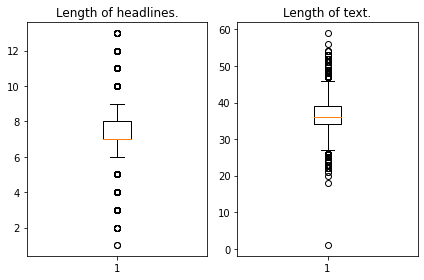

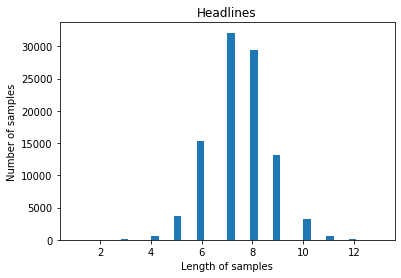

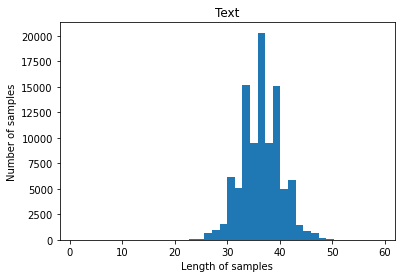

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axs = axes.ravel()

axs[0].boxplot(headlines_len)
axs[0].set_title("Length of headlines.")

axs[1].boxplot(text_len)
axs[1].set_title("Length of text.")

fig.tight_layout()

fig2, ax2 = plt.subplots()
ax2.hist(headlines_len, bins=40)
ax2.set_xlabel("Length of samples")
ax2.set_ylabel("Number of samples")
ax2.set_title("Headlines")

fig3, ax3 = plt.subplots()
ax3.hist(text_len, bins=40)
ax3.set_xlabel("Length of samples")
ax3.set_ylabel("Number of samples")
ax3.set_title("Text")

텍스트의 최대 길이는 45, 요약(headlines)의 최대길이는 8로 설정해서 문제를 풀어보겠습니다.

In [29]:
text_max_len = 45
headlines_max_len = 10

In [30]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt+1
            
    print(f"전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {cnt/len(nested_list):.2%}")

In [31]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 99.00%
전체 샘플 중 길이가 10 이하인 샘플의 비율: 99.33%


In [32]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print(f"전체 샘플수 : {len(data)}")

전체 샘플수 : 96762


In [33]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken ' + x) 
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al 90 salary...,saurav kant alumnus upgrad pg program machine ...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al 90 salary...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims not true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims not tru...,known hirani yrs metoo claims not true sonam e...
5,rahat fateh ali khan denies getting notice smu...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice smu...


In [34]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [35]:
indices = np.arange(encoder_input.shape[0])

rng = np.random.default_rng()
rng.shuffle(indices)

print(indices)

[18682 30259 15881 ...  4586 31618 51807]


In [36]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [37]:
n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수: ',  n_of_val)

테스트 데이터의 수:  19352


In [38]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77410
훈련 레이블의 개수 : 77410
테스트 데이터의 개수 : 19352
테스트 레이블의 개수 : 19352


In [39]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [41]:
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기: ", total_cnt)
print(f"등장빈도가 {threshold-1}번 이하인 희귀 단어의 수: {rare_cnt}")
print(f"단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: {total_cnt - rare_cnt}")
print("단어 집합에서 희귀 단어의 비율: ", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기:  70742
등장빈도가 8번 이하인 희귀 단어의 수: 50892
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 19850
단어 집합에서 희귀 단어의 비율:  71.94029006813491
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.226912827455185


In [42]:
src_vocab = 19800 ## 희귀 단어를 제외한 단어 집합의 크기
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [43]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[1810, 715, 1, 931, 1178, 413, 6876, 145, 677, 332, 690, 396, 2, 396, 531, 18, 293, 2, 34, 145, 1333, 1038, 1884, 531, 2097, 4, 241, 12804, 4654, 3491, 1810, 1], [183, 36, 7653, 290, 297, 185, 36, 92, 3967, 50, 2479, 1, 1133, 195, 136, 596, 28, 1166, 249, 195, 3783, 92, 15011, 482, 494, 432, 522, 9623, 1090, 2479, 4], [6, 3862, 151, 2417, 3763, 1090, 126, 463, 1206, 9, 22, 444, 2675, 4478, 1, 5017, 818, 5843, 11, 118, 677, 4, 6, 44, 5843, 17, 7758, 4212, 982, 16240, 10641, 1669, 3763, 5063, 748, 1556]]


In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [45]:
threshold = 9
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

        
print("단어 집합(vocabulary)의 크기: ", total_cnt)
print(f"등장빈도가 {threshold-1}번 이하인 희귀 단어의 수: {rare_cnt}")
print(f"단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: {total_cnt - rare_cnt}")
print("단어 집합에서 희귀 단어의 비율: ", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기:  31230
등장빈도가 8번 이하인 희귀 단어의 수: 22991
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기: 8239
단어 집합에서 희귀 단어의 비율:  73.61831572206212
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.446924250361397


In [46]:
tar_vocab = 8200
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ', decoder_input_train[:5])
print('target')
print('target ', decoder_target_train[:5])

input
input  [[1, 222, 2288, 338, 171, 1407], [1, 47, 642, 27, 887, 96, 1230], [1, 5394, 5395, 1668, 2591, 98, 5], [1, 1336, 5895, 164, 3126, 4214, 289], [1, 2178, 1599, 23, 60, 63, 413, 265, 35]]
target
target  [[222, 2288, 338, 171, 1407, 2], [47, 642, 27, 887, 96, 1230, 2], [5394, 5395, 1668, 2591, 98, 5, 2], [1336, 5895, 164, 3126, 4214, 289, 2], [2178, 1599, 23, 60, 63, 413, 265, 35, 2]]


In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 갯수: ', len(drop_train))
print('삭제할 테스트 데이터의 갯수: ', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 갯수: ', len(encoder_input_train))
print('훈련 레이블의 갯수: ', len(decoder_input_train))
print('테스트 데이터의 갯수: ', len(encoder_input_test))
print('테스트 레이블의 갯수: ', len(decoder_input_test))

삭제할 훈련 데이터의 갯수:  3
삭제할 테스트 데이터의 갯수:  1
훈련 데이터의 갯수:  77407
훈련 레이블의 갯수:  77407
테스트 데이터의 갯수:  19351
테스트 레이블의 갯수:  19351


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


의미가 덜 희석되는 pre-padding을 진행해보겠습니다.

In [48]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')




In [49]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len, ))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [50]:
decoder_inputs = Input(shape=(None, ))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [51]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2534400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [52]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [53]:
attn_layer = AttentionLayer(name='attention_layer')

attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2534400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [54]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
303/303 [==============================] - 245s 770ms/step - loss: 5.8794 - val_loss: 5.2263
Epoch 2/50
303/303 [==============================] - 234s 771ms/step - loss: 5.3124 - val_loss: 5.1340
Epoch 3/50
303/303 [==============================] - 234s 773ms/step - loss: 5.1934 - val_loss: 5.0413
Epoch 4/50
303/303 [==============================] - 233s 771ms/step - loss: 5.0794 - val_loss: 4.8806
Epoch 5/50
303/303 [==============================] - 234s 774ms/step - loss: 4.8741 - val_loss: 4.6885
Epoch 6/50
303/303 [==============================] - 232s 765ms/step - loss: 4.6378 - val_loss: 4.4517
Epoch 7/50
303/303 [==============================] - 228s 754ms/step - loss: 4.3822 - val_loss: 4.2867
Epoch 8/50
303/303 [==============================] - 227s 749ms/step - loss: 4.1790 - val_loss: 4.1350
Epoch 9/50
303/303 [==============================] - 226s 747ms/step - loss: 3.9932 - val_loss: 4.0208
Epoch 10/50
303/303 [==============================] - 228s 752m

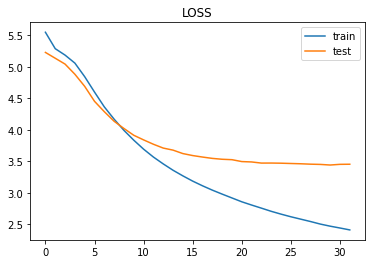

In [56]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LOSS')
plt.legend()
plt.show()

***val_loss가 약 3.4546정도에서 멈췄습니다.***

#### About preprocessing

간단한 전처리만 추가 해줬는데 생각보다 val_loss가 많이 줄어든 것을 확인할 수 있었습니다. 전처리를 잘하는 것이 얼마나 중요한 지 알 수 있었습니다. 전처리는 어떠한 문제를 푸느냐에 따라서 다양한 방식을 선택할 수 있습니다. 선택하느냐에 따라서 다양한 결과가 나올 수 있을 것 같습니다.

전처리를 할 때 처리하고 싶은 문장이 어떤 문장인 지 확인하기 위해서 가지고 있는 데이터셋을 잘 둘러보는 것이 중요하다는 생각이 들었습니다. 임의로 생각한 어떤 문장을 예쁘게 처리하더라고 실제로 문장안에서는 흔히 등장하지 않는 경우가 종종 있을 것 같습니다. 이번 전처리 과정에서도 사실 '5mm'과 같은 단어는 그대로 두고 '5pp'와 같은 문장은 지워주고 싶었습니다. 알파벳이 두번 연속으로 등장할 때, 'mm'을 제외하면 모두 의미가 없는 단어라고 생각했기 때문입니다. 이 부분에 대해서는 별도로 처리는 하지 않았지만 만약 실제로 데이터에서 흔히 등장하지 않는다면 처리가 필요없을 수도 있을거라는 생각이 들기도 했습니다.

또한 세번 등장하는 알파벳을 지웠는데, 아무래도 뉴스다 보니 기관이름 등이 등장할 수 있겠네요. 예를들어 'WWW(World Wide Web)'이 등장할 수도 있는데 여기서는 그대로 지워버립니다. 하지만 통상적으로는 World Wide Web(WWW)와 같은식으로 표기를 할 것이기 때문에 깊이 나눠서 처리를 해주지는 않았습니다.

이처럼 다양한 전처리를 해볼 수 있고, 이런 전처리를 통해 성능이 어떻게 변하는 지 살펴보는 것도 유의미한 실험이 되지 않을까 생각이 듭니다. 중요한 건 모든 문제에 적용할 수 있는 마스터 키 같은 전처리는 없다는 것입니다.

## Inference Model

In [57]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [58]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [59]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [60]:
def decode_sequence(input_seq):
    
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if (sampled_token != 'eostoken'):
            decoded_sentence += ' ' + sampled_token
            
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        e_h, e_c = h, c
        
    return decoded_sentence

In [61]:
def seq2text(input_seq):
    temp = ''
    
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i] + ' '
    
    return temp

def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
            
    return temp

In [62]:
for i in range(44, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : rebel jd leader sharad yadav tuesday moved delhi high court disqualification rajya sabha yadav claimed not given chance authorities order passed earlier vice president venkaiah naidu said yadav voluntarily left party speaking publicly thus disqualification 
실제 요약 : sharad yadav moves hc rajya sabha disqualification 
예측 요약 :  sharad yadav rejects sharad yadav plea not leave india


원문 : british academic matthew sentenced life spying uae immediate effect 31 year old denied spying said country security strategy part phd studies durham university pardon part mass 700 prisoners mark uae national day 
실제 요약 : uae british sentenced life spying 
예측 요약 :  uae man uae spying uae get death sentence dubai


원문 : president ram nath kovind gave acceptance speech parliament sworn 14th president feel privileged walk path dr radhakrishnan dr abdul kalam pranab da said also thanked present responsibility president india 
실제 요약 : walk path kalam pranab da kovind 
예측 요약 :  president kovind prez kovin

#### Text degeneration problem
어느정도 val_loss를 낮췄음에도 불구하고 예측 요약에서 계속 똑같은 단어가 반복해서 등장합니다. 이러한 문제를 Text degeneration이라 하고 [논문](https://arxiv.org/pdf/1904.09751.pdf)을 통해 자세한 내용을 확인할 수 있습니다. 

여기서는 간단한 방법을 몇가지 생각해봤는데, 첫번째는 top-3 정답을 뽑아낸다음 하나씩 출력하는 것이였습니다. 이에 대해서 구현을 하려고 했으나 시간이 부족해 현재는 진행하지 못한 상황입니다. 두번째로는 안형준님이 올려주신 정답을 참고해 작성한 penalty를 부여하는 방식입니다. 해당 방식은 이미 등장한 단어에 일정한 penalty를 부여해 최대값이 되기 힘들도록 만드는 방식으로 자세한 내용은 [이 곳](https://aiffel.agit.io/g/300307140/wall/324648437)에서 찾아볼 수 있습니다.

In [65]:
def decode_sequence_penalty(input_seq):

    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    token_bag = set()

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        if sampled_token_index in token_bag:
            output_tokens[0, -1, sampled_token_index] *= 0.15
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
        

        sampled_token = tar_index_to_word[sampled_token_index]
        
        token_bag.add(sampled_token_index)

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [66]:
for i in range(44, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence_penalty(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : rebel jd leader sharad yadav tuesday moved delhi high court disqualification rajya sabha yadav claimed not given chance authorities order passed earlier vice president venkaiah naidu said yadav voluntarily left party speaking publicly thus disqualification 
실제 요약 : sharad yadav moves hc rajya sabha disqualification 
예측 요약 :  sharad yadav rejects plea seeking leave india not disqualification


원문 : british academic matthew sentenced life spying uae immediate effect 31 year old denied spying said country security strategy part phd studies durham university pardon part mass 700 prisoners mark uae national day 
실제 요약 : uae british sentenced life spying 
예측 요약 :  uae man jailed spying uae not give spy scandal


원문 : president ram nath kovind gave acceptance speech parliament sworn 14th president feel privileged walk path dr radhakrishnan dr abdul kalam pranab da said also thanked present responsibility president india 
실제 요약 : walk path kalam pranab da kovind 
예측 요약 :  president kovind

## 추출적 요약
간단하게 추출적 요약을 해보면서 마무리 하겠습니다.

In [85]:
import requests
from summa.summarizer import summarize

In [97]:
data = original_data

In [124]:
print(text)
print('----------')
print('Summary: ')
print(summarize(text, ratio=0.8))

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
----------
Summary: 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


In [128]:
data['EXheadlines'] = data['text'].apply(lambda x: summarize(x, ratio=0.8))

In [129]:
data.head()

,headlines,text,EXheadlines
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",The program and upGrad's 360-degree career sup...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,"Pranav Kaushik, a Delhi techie, bagged this re..."
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",The plan provides life cover up to the age of ...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,Speaking about the sexual harassment allegatio...


## 소감

군데군데 짤막한 생각과 소감을 남겨 간단하게 소감을 쓰며 마무리 하겠습니다.

정규표현식을 열심히 써가며 전처리를 하고 성능이 좋아져서 기분은 좋았습니다. attention을 다르게 연결하는 방법, transformer를 사용하는 방법등 다양한 방법을 사용해 성능을 체크해보고 싶었지만 게을러 해보지 못해 아쉽습니다. 조금 더 부지런하게 차근차근 다 해봐야겠습니다.

자연어처리는 항상 학습시간이 오래 걸려서 더욱 힘드네요.